In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### Residual Block

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

#### Generator

In [3]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        
        # Inital Convolution  3*256*256 -> 64*256*256
        out_channels=64
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, out_channels, 2*in_channels+1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
        channels = out_channels
        
        # Downsampling   64*256*256 -> 128*128*128 -> 256*64*64
        self.down = []
        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)
        
        # Transformation (ResNet)  256*64*64
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)
        
        # Upsampling  256*64*64 -> 128*128*128 -> 64*256*256
        self.up = []
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor=2), # bilinear interpolation
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)
        
        # Out layer  64*256*256 -> 3*256*256
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x

#### Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # why normalize=False?
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32
            *self.block(256, 512), # 256*32*32 -> 512*16*16
            
            # Why padding first then convolution?
            nn.ZeroPad2d((1,0,1,0)), # padding left and top   512*16*16 -> 512*17*17
            nn.Conv2d(512, 1, 4, padding=1) # 512*17*17 -> 1*16*16
        )
        
        self.scale_factor = 16
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, x):
        return self.model(x)

#### Loss

In [5]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

#### Initalize G and D

In [6]:
G_AB = GeneratorResNet(3)
D_B = Discriminator(3)

G_BA = GeneratorResNet(3)
D_A = Discriminator(3)

In [7]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')

cuda: True


In [8]:
if cuda:
    G_AB = G_AB.cuda()
    D_B = D_B.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    
    criterion_GAN = criterion_GAN.cuda()
    criterion_cycle = criterion_cycle.cuda()
    criterion_identity = criterion_identity.cuda()

#### optimizers

In [9]:
import itertools
lr = 0.0002
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2))

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1, b2))

optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1, b2))

#### Learning Rate Scheduler Setting

In [10]:
n_epoches = 100
decay_epoch = 20

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)

#### DataLoacer

In [11]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, data_dir, mode='train', transforms=None):
        A_dir = os.path.join(data_dir, 'monet_jpg')
        B_dir = os.path.join(data_dir, 'photo_jpg')
        
        if mode == 'train':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[:250]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[:250]]
        elif mode == 'test':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[250:]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[250:301]]
        
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files_A)
    
    def __getitem__(self, index):
        file_A = self.files_A[index]
        file_B = self.files_B[index]
        
        img_A = Image.open(file_A)
        img_B = Image.open(file_B)
        
        if self.transforms is not None:
            img_A = self.transforms(img_A)
            img_B = self.transforms(img_B)
        
        return img_A, img_B

In [12]:
import torchvision.transforms as transforms

data_dir = 'data/gan-getting-started/'

transforms_ = transforms.Compose([
   # transforms.Resize(int(256*1.12), Image.BICUBIC),
    #transforms.RandomCrop(256, 256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 5

trainloader = DataLoader(
    ImageDataset(data_dir, mode='train', transforms=transforms_),
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0
)

testloader = DataLoader(
    ImageDataset(data_dir, mode='test', transforms=transforms_),
    batch_size = batch_size,
    shuffle = False,
    num_workers = 0
)

In [13]:
from torchvision.utils import make_grid

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

def sample_images(real_A, real_B, figside=1.5):
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'
    
    G_AB.eval()
    G_BA.eval()
    
    real_A = real_A.type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()
    
    nrows = real_A.size(0)
    real_A = make_grid(real_A, nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
    real_B = make_grid(real_B, nrow=nrows, normalize=True)
    fake_A = make_grid(fake_A, nrow=nrows, normalize=True)
    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1).cpu().permute(1, 2, 0)
    
    plt.figure(figsize=(figside*nrows, figside*4))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()

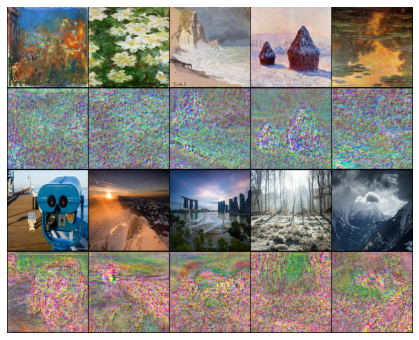

In [14]:
real_A, real_B = next(iter(testloader))
sample_images(real_A, real_B)

#### training

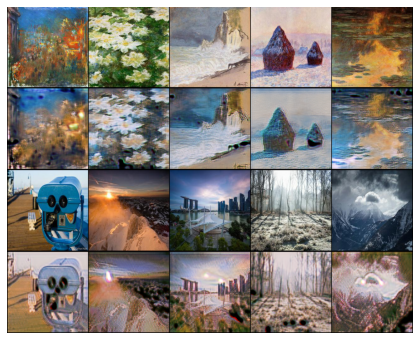

[Epoch 10/100]
[G loss: 3.690093517303467 | identity: 0.2139396369457245 GAN: 0.6706528663635254 cycle: 0.19497422873973846]
[D loss: 0.10589036345481873 | D_A: 0.05757499486207962 D_B: 0.15420572459697723]


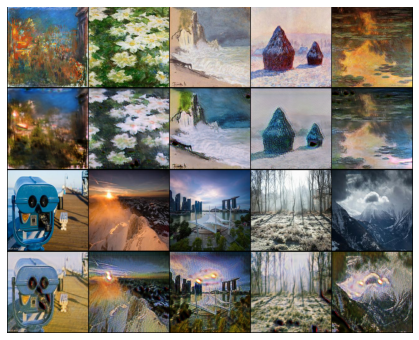

[Epoch 20/100]
[G loss: 3.4532032012939453 | identity: 0.19065847992897034 GAN: 0.7566394805908203 cycle: 0.17432714998722076]
[D loss: 0.07942633330821991 | D_A: 0.06445194780826569 D_B: 0.09440071135759354]


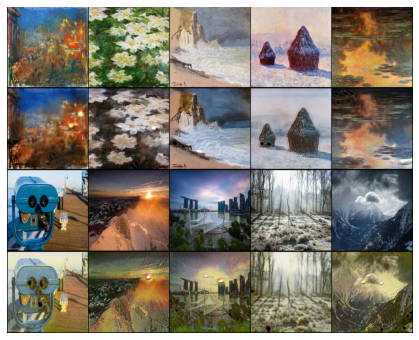

[Epoch 30/100]
[G loss: 3.4043190479278564 | identity: 0.20644357800483704 GAN: 0.46785497665405273 cycle: 0.1904246211051941]
[D loss: 0.2190019190311432 | D_A: 0.2520819902420044 D_B: 0.1859218329191208]


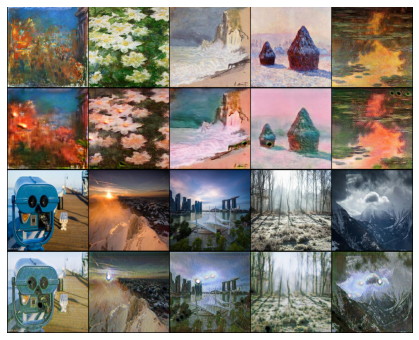

[Epoch 40/100]
[G loss: 3.5484976768493652 | identity: 0.20540708303451538 GAN: 0.5953179597854614 cycle: 0.19261442124843597]
[D loss: 0.14298000931739807 | D_A: 0.13095715641975403 D_B: 0.15500284731388092]


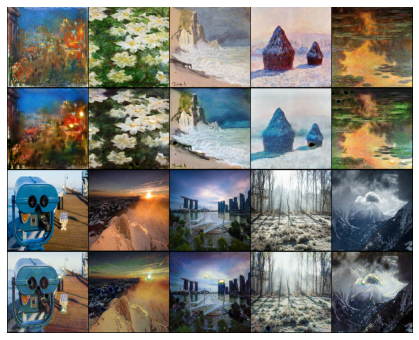

[Epoch 50/100]
[G loss: 3.0909061431884766 | identity: 0.17594492435455322 GAN: 0.533312201499939 cycle: 0.16778694093227386]
[D loss: 0.24081812798976898 | D_A: 0.290483295917511 D_B: 0.19115296006202698]


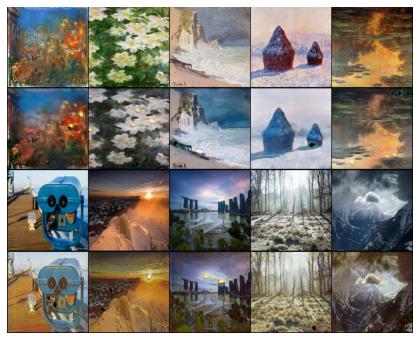

[Epoch 60/100]
[G loss: 2.7936811447143555 | identity: 0.1752464473247528 GAN: 0.44806361198425293 cycle: 0.1469385325908661]
[D loss: 0.14441241323947906 | D_A: 0.11684953421354294 D_B: 0.1719752848148346]


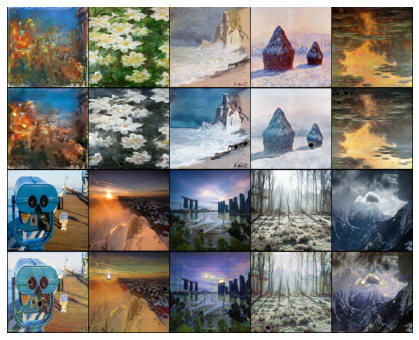

[Epoch 70/100]
[G loss: 2.917558431625366 | identity: 0.14678141474723816 GAN: 0.9014774560928345 cycle: 0.12821738421916962]
[D loss: 0.13131104409694672 | D_A: 0.10665722191333771 D_B: 0.15596486628055573]


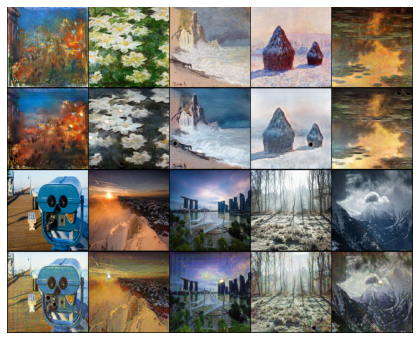

[Epoch 80/100]
[G loss: 2.490055561065674 | identity: 0.15768195688724518 GAN: 0.5402023792266846 cycle: 0.11614435911178589]
[D loss: 0.11982391774654388 | D_A: 0.13200370967388153 D_B: 0.10764413326978683]


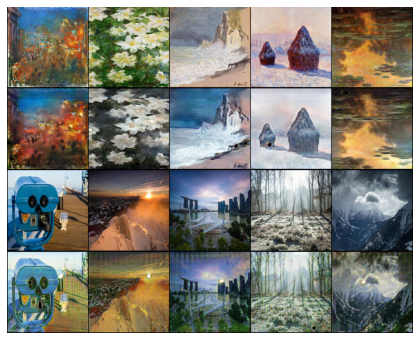

[Epoch 90/100]
[G loss: 2.716859817504883 | identity: 0.1777942180633545 GAN: 0.5806216597557068 cycle: 0.12472669780254364]
[D loss: 0.08755093812942505 | D_A: 0.08460915833711624 D_B: 0.09049272537231445]


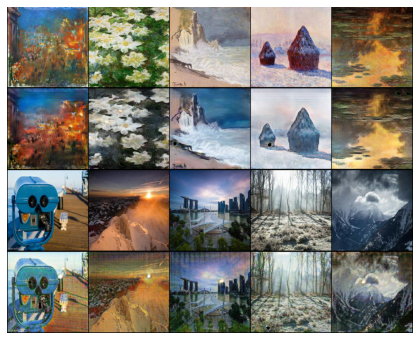

[Epoch 100/100]
[G loss: 2.2549986839294434 | identity: 0.1418001651763916 GAN: 0.4904167652130127 cycle: 0.10555810481309891]
[D loss: 0.13556301593780518 | D_A: 0.2002766877412796 D_B: 0.07084934413433075]


In [15]:
for epoch in range(n_epoches): # epoch 만큼 반복
    for i, (real_A, real_B) in enumerate(trainloader): # trainloader에서 real data 받아오면서,횟수도 받아옴
        real_A, real_B = real_A.type(Tensor), real_B.type(Tensor)# 텐서로 전환
        
        # groud truth
        out_shape = [real_A.size(0), 1, real_A.size(2)//D_A.scale_factor, real_A.size(3)//D_A.scale_factor]
        valid = torch.ones(out_shape).type(Tensor) # real label 1로 채우기
        
        
        fake = torch.zeros(out_shape).type(Tensor) # fake label 0으로 채우기
        
        """Train Generators"""
        # set to training mode in the begining, beacause sample_images will set it to eval mode
        G_AB.train() # train모드
        G_BA.train() # train모드
        
        optimizer_G.zero_grad()
        
        fake_B = G_AB(real_A) # real_A로 가짜 B
        fake_A = G_BA(real_B) # real_B로 가짜 A
        
        # identity loss
        loss_id_A = criterion_identity(fake_B, real_A) #  nn.L1Loss()   # 얼룩말을 넣었을때 다시 얼굴말이 나오게하는 loss
        loss_id_B = criterion_identity(fake_A, real_B) #  nn.L1Loss()
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss, train G to make D think it's true
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # nn.MSELoss()
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # nn.MSELoss()
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)  #  nn.L1Loss()
        loss_cycle_B = criterion_cycle(recov_B, real_B)  #  nn.L1Loss() 
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # G totol loss
        loss_G = 5.0*loss_identity + loss_GAN + 10.0*loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        """Train Discriminator A"""
        optimizer_D_A.zero_grad()
        
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        
        loss_D_A.backward()
        optimizer_D_A.step()
        
        """Train Discriminator B"""
        optimizer_D_B.zero_grad()
        
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        
        loss_D_B.backward()
        optimizer_D_B.step()
    
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    # test
    if (epoch+1) % 10 == 0:
        test_real_A, test_real_B = next(iter(testloader))
        sample_images(test_real_A, test_real_B)

        loss_D = (loss_D_A + loss_D_B) / 2
        print(f'[Epoch {epoch+1}/{n_epoches}]')
        print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
        print(f'[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item()}]')    